# Proposal

The purpose of this project is to extract the essence of the dataset and generate a new dataset (bigger and/or smaller) from this. We supposed that dataset essence is in the dataset distribution (attributes and categories) so we will generate new datasets from the `PDFs` (`PDF` by category) which will be estimated from orignal dataset using `Kernel Density Estimation`.

## Test Dataset Generation

For this proposal it will be necessary to generate a test dataset with just one feature and two categories. The purpose of this is to understand better the proposed methods.

The test dataset has 300 instances, 1 feature and 2 categories (150 instances per category).

We are looking for an univariate dataset in which exists overlap (just a little) between category distributions. To check this we will plot the generated dataset.

Figure 1: Dataset distributions by category


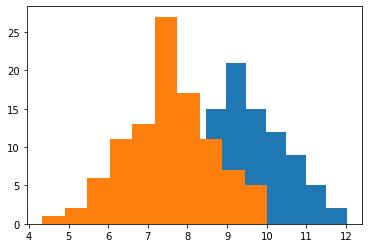

In [1]:
from kde_dataset_generator import dataset

# Dataset params
size = 200
n_categories = 2
seed = 8

# Generate df
df = dataset.generate_univariate_dataset(size, n_categories, seed)

# Plot df
print("Figure 1: Dataset distributions by category")
dataset.plot_univariate(df)


## Calculate KDEs by category

We needs to extract knowledge from dataset. To achieve this `PDFs` are estimated for each category using `KDE`.

In [2]:
from kde_dataset_generator import kde as lkde

# Caculate KDEs
kdes = lkde.calculate_kdes(df)

To make sure `PDFs` estimation are right, we plot category distributions using the previous calculated `KDEs`.

Figure 2: Dataset distributions by category using KDEs based


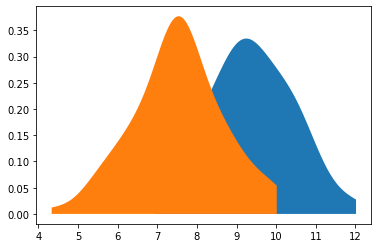

In [3]:
print("Figure 2: Dataset distributions by category using KDEs based")
lkde.plot_univariate(df, kdes)

The distributions represented in charts are the same, so we concludes that `KDEs` are right.

## The theorical method


To simplify the method analysis we will only focus on one distribution from all (one distribution per category).

We will take only values associated to category `0` and plot them.

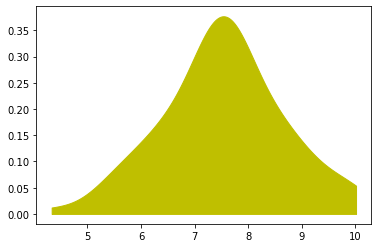

In [4]:
# Get dataset with only values associated to category 0
filtered_df = df[df.iloc[:,-1] == 0]

# Get KDE
kde = kdes[0]

# Plot dataset distribution
lkde.plot_univariate_single(filtered_df, kde)
